# Hurricane Damage Detector

The primary objective of this project is to leverage an open dataset comprising satellite imagery data to identify damaged buildings following a hurricane. Specifically, this satellite imagery is drawn from the aftermath of Hurricane Harvey in 2017. The goal is to construct a classifier that can ascertain if a certain region (based on the input satellite image) is likely to have suffered from water inundation and other typical structural damage from Hurricane Harvey. This will be a binary classification task. 
The dataset, sourced from: https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized, will be invaluable for this purpose.

# Install the required Python packages

In [ ]:
!pip install --upgrade --no-cache-dir tensorflow numpy pandas matplotlib scikit-learn tqdm glob gdown

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [2]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=149da2eb-3940-4162-ba02-ae2c41a59098
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:08<00:00, 4.46MB/s]


In [3]:
!unzip -q hurricane_detector.zip

In [4]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Apr  5 02:31 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 26 17:02 sample_data/
drwxr-xr-x 4 root root     4096 Jun 28 13:08 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 28 13:08 train_hurricane/


In [5]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (54.9 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121925 files and directories currently instal

In [6]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage  [655 entries exceeds filelimit, not opening dir]
└── no_damage  [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage  [5895 entries exceeds filelimit, not opening dir]
└── no_damage  [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import random

print('TF Version:', tf.__version__)

TF Version: 2.15.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )


    train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    predictions = (predictions > 0.5).astype(int).ravel()
    test_labels = np.array(test_labels)

    # Plot 10 random images with their predictions
    def visualize_predictions(num_samples=10):
        # Randomly select a subset of images
        test_images = []
        for imgs, _ in test_ds.unbatch().take(len(test_labels)):
            test_images.append(imgs.numpy())

        selected_indices = random.sample(range(len(test_images)), num_samples)
        selected_images = [test_images[i] for i in selected_indices]
        selected_labels = [test_labels[i] for i in selected_indices]
        selected_predictions = [predictions[i] for i in selected_indices]

        # Plot the images with their predicted labels
        plt.figure(figsize=(20, 20))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(selected_images[i].astype(np.uint8))
            plt.title(f'Pred: {selected_predictions[i]}, Actual: {selected_labels[i]}', fontsize=10)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    visualize_predictions(num_samples=10)


    return test_labels, predictions


## Define the CNN network as our baseline model

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train en evaluate the model

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.
Epoch 1/15
34/34 [==============================] - 15s 46ms/step - loss: 12.1414 - accuracy: 0.5308 - val_loss: 1.6595 - val_accuracy: 0.5461
Epoch 2/15
34/34 [==============================] - 1s 23ms/step - loss: 0.9219 - accuracy: 0.6467 - val_loss: 0.5245 - val_accuracy: 0.7601
Epoch 3/15
34/34 [==============================] - 1s 19ms/step - loss: 0.8400 - accuracy: 0.6274 - val_loss: 0.7971 - val_accuracy: 0.6384
Epoch 4/15
34/34 [==============================] - 1s 19ms/step - loss: 0.6709 - accuracy: 0.6743 - val_loss: 0.7458 - val_accuracy: 0.6790
Epoch 5/15
34/34 [==============================] - 2s 29ms/step - loss: 0.6592 - accuracy: 0.7093 - val_loss: 0.6588 - val_accuracy: 0.6679
Epoch 6/15
34/34 [==============================] - 2s 29ms/step - loss: 0.5974 - accuracy: 0.7341 - val_loss: 0.5885 - val_accuracy: 0.6937
Epoch 7

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:48,  1.94it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:28,  3.30it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:22,  4.11it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:00<00:18,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:16,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:15,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:14,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:14,  6.22it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:14,  6.00it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:01<00:14,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:14,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:13,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:13,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:02<00:12,  6.47it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:02<00:12,  6.50it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:02<00:12,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:03<00:12,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:11,  6.69it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:11,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:03<00:11,  6.48it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:03<00:11,  6.70it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:03<00:11,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:03<00:11,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:11,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:04<00:10,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:04<00:10,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:04<00:10,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:04<00:10,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:04<00:10,  6.64it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:04<00:10,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:05<00:10,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:05<00:10,  6.36it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:05<00:09,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:05<00:09,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:05<00:09,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:05<00:09,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:08,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:08,  6.79it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:06<00:08,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:06<00:08,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:06<00:08,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:06<00:08,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:06<00:08,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:07,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:07<00:08,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:07<00:08,  6.20it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:07<00:07,  6.13it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:07<00:08,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:07<00:07,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:09,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:08<00:08,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:08<00:07,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:08<00:07,  5.76it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:08<00:07,  5.98it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:06,  6.32it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:06,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:09<00:07,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:09<00:07,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:09<00:07,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:07,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:07,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:07,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:10<00:07,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:10<00:07,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:06,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:06,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:06,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:06,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:12<00:05,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:12<00:04,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:04,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:03,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:12<00:03,  6.34it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:13<00:03,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:02,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:02,  6.50it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:02,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:13<00:02,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:02,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:01,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:14<00:01,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:14<00:01,  6.97it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:14<00:01,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:14<00:01,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:01,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:15<00:00,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:15<00:00,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:15<00:00,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:15<00:00,  6.90it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:15<00:00,  6.89it/s]

3/3 [==============================] - 0s 80ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:16<00:00,  5.87it/s]


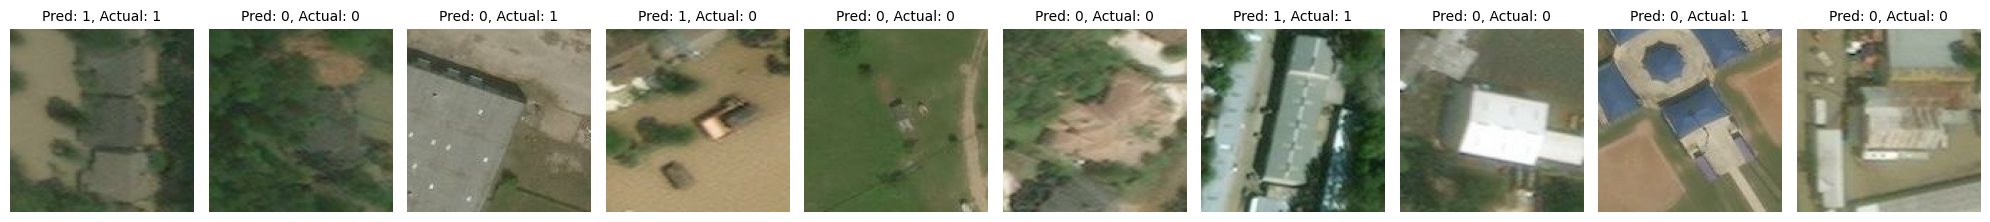

In [12]:
epochs = 15

train_ds, val_ds = prepare_train_and_val_datasets()
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

)

y_true, y_pred = eval_model_on_test(model)

In [13]:
eval = classification_report(y_true, y_pred)
print(eval)

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      6333
           1       0.82      0.58      0.68      5895

    accuracy                           0.73     12228
   macro avg       0.75      0.73      0.72     12228
weighted avg       0.75      0.73      0.73     12228



# Plot the Accuracy and Loss or our model through the epochs

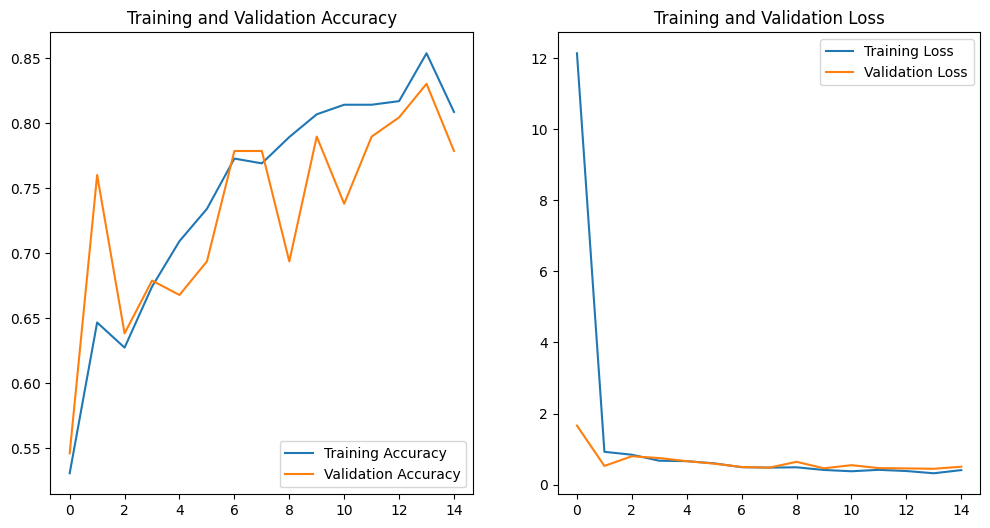

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Now Let's use the Resnet50 to see if we get a better prediction

In [17]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                  include_top = False,
                                                   weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [18]:
print(base_model.layers[0].output_shape[0])
input_shape = base_model.layers[0].output_shape[0][1:3]
input_shape

(None, 128, 128, 3)


(128, 128)

Since we just want to use the resnet50 model as it it with no fine tuning we fresze all layers

In [19]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [20]:
base_model.trainable = False

In [21]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

# Define our neural net with the resnet50 model

In [22]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
pre_img = tf.keras.applications.resnet.preprocess_input(inputs)
res_model_fm = base_model(inputs, training=False)
feature_vecs = tf.keras.layers.GlobalAveragePooling2D()(res_model_fm)
dense1 = tf.keras.layers.Dense(256)(feature_vecs)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(drop1)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                             

In [25]:
for layer in model.layers:
    print(layer.name, '->', layer.trainable)

input_2 -> True
resnet50 -> False
global_average_pooling2d -> True
dense_2 -> True
dropout_1 -> True
dense_3 -> True


In [26]:
train_ds, val_ds = prepare_train_and_val_datasets()


loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.
9/9 [==============================] - 5s 144ms/step - loss: 1.0471 - accuracy: 0.5018
initial loss: 1.05
initial accuracy: 0.50


In [28]:
initial_epochs = 10


history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

Epoch 1/10
34/34 [==============================] - 7s 88ms/step - loss: 0.4979 - accuracy: 0.7718 - val_loss: 0.3472 - val_accuracy: 0.8524
Epoch 2/10
34/34 [==============================] - 3s 55ms/step - loss: 0.2962 - accuracy: 0.8712 - val_loss: 0.2951 - val_accuracy: 0.8930
Epoch 3/10
34/34 [==============================] - 2s 51ms/step - loss: 0.2086 - accuracy: 0.9144 - val_loss: 0.2790 - val_accuracy: 0.8967
Epoch 4/10
34/34 [==============================] - 2s 51ms/step - loss: 0.1944 - accuracy: 0.9282 - val_loss: 0.2522 - val_accuracy: 0.9077
Epoch 5/10
34/34 [==============================] - 2s 46ms/step - loss: 0.1785 - accuracy: 0.9282 - val_loss: 0.2594 - val_accuracy: 0.9225
Epoch 6/10
34/34 [==============================] - 2s 47ms/step - loss: 0.1635 - accuracy: 0.9347 - val_loss: 0.2642 - val_accuracy: 0.9225
Epoch 7/10
34/34 [==============================] - 3s 62ms/step - loss: 0.1662 - accuracy: 0.9356 - val_loss: 0.2512 - val_accuracy: 0.9225
Epoch 8/10
34

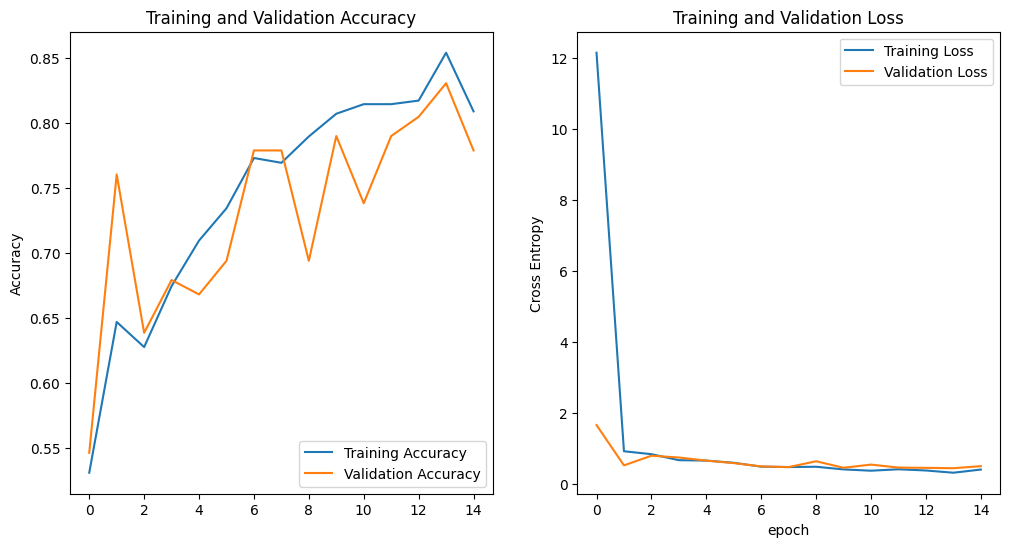

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 46ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:17,  1.44s/it]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<01:09,  1.36it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:01<00:48,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:37,  2.44it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:32,  2.81it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:29,  3.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:28,  3.15it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:28,  3.14it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:27,  3.15it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:03<00:28,  3.05it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:27,  3.08it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:27,  3.04it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:26,  3.09it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:26,  3.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:25,  3.19it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:23,  3.44it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:06<00:21,  3.60it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:20,  3.72it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:06<00:20,  3.82it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:06<00:20,  3.77it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:19,  3.90it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:07<00:18,  3.96it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:07<00:18,  4.00it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:07<00:18,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:08<00:17,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:08<00:17,  4.03it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:08<00:16,  4.09it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:08<00:16,  4.04it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:09<00:16,  4.11it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:09<00:16,  4.10it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:15,  4.10it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:09<00:15,  4.14it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:15,  4.04it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:10<00:15,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:10<00:14,  4.08it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:10<00:14,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:10<00:14,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:11<00:14,  4.07it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:11<00:13,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:11<00:13,  4.02it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:11<00:13,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:12<00:13,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:12<00:13,  4.05it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:12<00:12,  4.07it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:12<00:12,  3.96it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:13<00:12,  4.04it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:13<00:12,  4.08it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:13<00:11,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:13<00:11,  4.02it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:14<00:11,  4.05it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:14<00:10,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:14<00:10,  4.09it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:14<00:10,  4.07it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:15<00:10,  4.05it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:15<00:10,  3.96it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:15<00:10,  3.73it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:16<00:10,  3.57it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:16<00:11,  3.40it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:16<00:11,  3.34it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:17<00:11,  3.25it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:17<00:10,  3.22it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:17<00:12,  2.74it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:18<00:11,  2.90it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:18<00:09,  3.22it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:18<00:09,  3.41it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:18<00:08,  3.65it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:19<00:07,  3.77it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:19<00:07,  3.85it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:19<00:06,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:19<00:06,  3.98it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:20<00:06,  4.01it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:05,  4.06it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:20<00:05,  4.12it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:20<00:05,  4.06it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:21<00:05,  4.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:04,  4.16it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:21<00:04,  4.14it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:21<00:04,  4.01it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:22<00:04,  4.01it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:22<00:03,  4.05it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:03,  4.01it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:22<00:03,  3.99it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:23<00:03,  4.04it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:23<00:03,  3.84it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  3.93it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:23<00:02,  3.93it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:24<00:02,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:24<00:01,  4.06it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.14it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  4.21it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:24<00:01,  4.21it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:25<00:00,  4.25it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:25<00:00,  4.31it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  4.33it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:25<00:00,  4.34it/s]

3/3 [==============================] - 2s 381ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


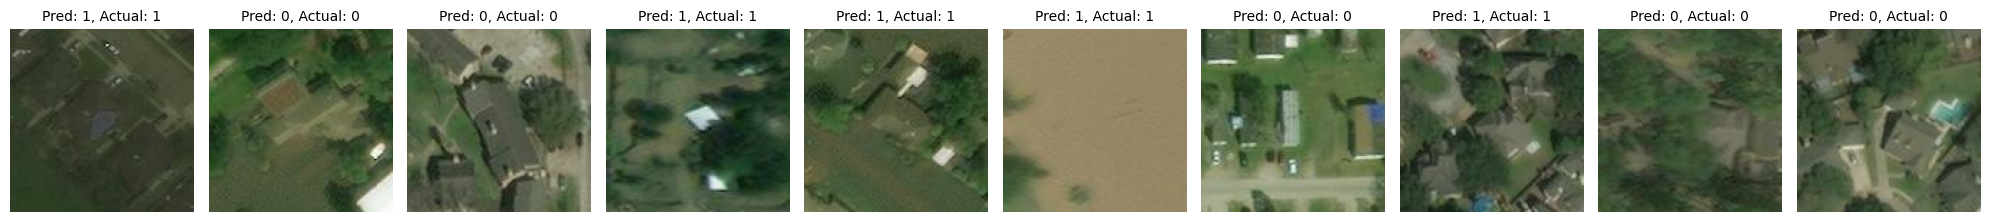

In [29]:
y_true, y_pred = eval_model_on_test(model)

In [30]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6333
           1       0.96      0.87      0.91      5895

    accuracy                           0.92     12228
   macro avg       0.93      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228



# We got quite an improvement by using the resnet50 model no lets try to fine tune it

In [31]:
# unfrezze all layers
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [32]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [33]:
# Fine-tune from this layer onwards
fine_tune_at = 143

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [34]:
for index, layer in enumerate(base_model.layers):
  print(index, ':', layer.name, '->', layer.trainable)

0 : input_1 -> False
1 : conv1_pad -> False
2 : conv1_conv -> False
3 : conv1_bn -> False
4 : conv1_relu -> False
5 : pool1_pad -> False
6 : pool1_pool -> False
7 : conv2_block1_1_conv -> False
8 : conv2_block1_1_bn -> False
9 : conv2_block1_1_relu -> False
10 : conv2_block1_2_conv -> False
11 : conv2_block1_2_bn -> False
12 : conv2_block1_2_relu -> False
13 : conv2_block1_0_conv -> False
14 : conv2_block1_3_conv -> False
15 : conv2_block1_0_bn -> False
16 : conv2_block1_3_bn -> False
17 : conv2_block1_add -> False
18 : conv2_block1_out -> False
19 : conv2_block2_1_conv -> False
20 : conv2_block2_1_bn -> False
21 : conv2_block2_1_relu -> False
22 : conv2_block2_2_conv -> False
23 : conv2_block2_2_bn -> False
24 : conv2_block2_2_relu -> False
25 : conv2_block2_3_conv -> False
26 : conv2_block2_3_bn -> False
27 : conv2_block2_add -> False
28 : conv2_block2_out -> False
29 : conv2_block3_1_conv -> False
30 : conv2_block3_1_bn -> False
31 : conv2_block3_1_relu -> False
32 : conv2_block3_2_

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Fine-tune the model with unfrozen layers
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

Epoch 1/10
34/34 [==============================] - 14s 119ms/step - loss: 0.1137 - accuracy: 0.9623 - val_loss: 0.2484 - val_accuracy: 0.9262
Epoch 2/10
34/34 [==============================] - 3s 69ms/step - loss: 0.0903 - accuracy: 0.9650 - val_loss: 0.2390 - val_accuracy: 0.9114
Epoch 3/10
34/34 [==============================] - 3s 75ms/step - loss: 0.0536 - accuracy: 0.9834 - val_loss: 0.2716 - val_accuracy: 0.9299
Epoch 4/10
34/34 [==============================] - 3s 67ms/step - loss: 0.0425 - accuracy: 0.9853 - val_loss: 0.2417 - val_accuracy: 0.9336
Epoch 5/10
34/34 [==============================] - 3s 66ms/step - loss: 0.0521 - accuracy: 0.9788 - val_loss: 0.2464 - val_accuracy: 0.9336
Epoch 6/10
34/34 [==============================] - 3s 78ms/step - loss: 0.0316 - accuracy: 0.9936 - val_loss: 0.2612 - val_accuracy: 0.9262
Epoch 7/10
34/34 [==============================] - 3s 70ms/step - loss: 0.0291 - accuracy: 0.9890 - val_loss: 0.2961 - val_accuracy: 0.9299


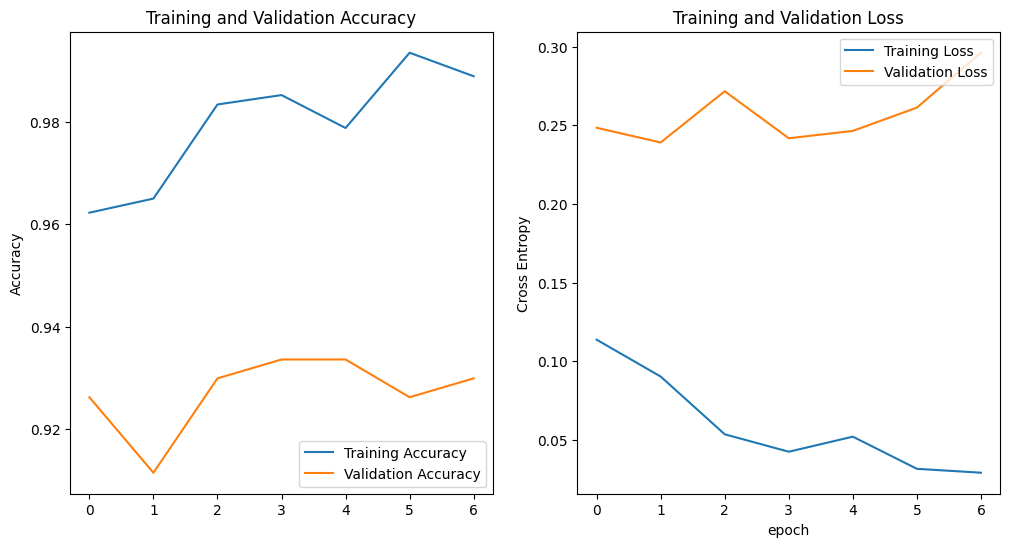

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 2s 51ms/step


Predicting on Test Data:   1%|          | 1/96 [00:02<03:42,  2.34s/it]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:45,  1.13s/it]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<01:09,  1.34it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:03<00:50,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:03<00:40,  2.25it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:03<00:34,  2.62it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:29,  2.97it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:04<00:27,  3.21it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:04<00:25,  3.43it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:04<00:24,  3.51it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:23,  3.64it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:05<00:22,  3.80it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:05<00:21,  3.82it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:21,  3.86it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:20,  3.92it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:06<00:20,  3.97it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:06<00:19,  3.96it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:20,  3.89it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:06<00:19,  3.95it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:07<00:19,  3.93it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:19,  3.90it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:07<00:18,  3.91it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:07<00:18,  3.97it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:08<00:18,  3.95it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:08<00:17,  3.96it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:08<00:17,  3.96it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:08<00:17,  3.96it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:09<00:17,  3.99it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:09<00:16,  4.07it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:09<00:16,  3.94it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:16,  3.92it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:10<00:16,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:15,  4.02it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:10<00:15,  4.00it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:10<00:15,  4.03it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:11<00:14,  4.07it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:11<00:14,  4.10it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:11<00:14,  4.03it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:11<00:14,  4.05it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:12<00:13,  4.03it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:12<00:14,  3.91it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:12<00:14,  3.63it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:13<00:15,  3.50it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:13<00:14,  3.53it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:13<00:15,  3.35it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:14<00:15,  3.33it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:14<00:14,  3.29it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:14<00:17,  2.74it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:15<00:15,  2.95it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:15<00:14,  3.20it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:15<00:13,  3.46it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:15<00:12,  3.57it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:16<00:11,  3.71it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:16<00:10,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:16<00:10,  3.92it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:16<00:10,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:17<00:09,  3.99it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:17<00:09,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:17<00:09,  4.07it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:17<00:09,  3.99it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:18<00:08,  4.05it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:18<00:08,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:18<00:08,  4.10it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:18<00:07,  4.10it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:19<00:07,  4.04it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:19<00:07,  4.04it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:19<00:07,  4.06it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:19<00:06,  4.07it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:20<00:06,  4.04it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:20<00:06,  4.05it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:20<00:06,  4.11it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:05,  4.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:21<00:05,  4.02it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:21<00:05,  3.98it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:21<00:05,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:05,  3.96it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:22<00:04,  4.03it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:22<00:04,  4.03it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:22<00:04,  4.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:22<00:03,  4.13it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:23<00:03,  4.10it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:23<00:03,  4.08it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:23<00:03,  4.06it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:23<00:02,  4.10it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  4.11it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:24<00:02,  4.15it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:24<00:02,  4.26it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:24<00:01,  4.28it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.22it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:25<00:01,  4.08it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:25<00:01,  3.89it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:25<00:01,  3.70it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:26<00:00,  3.62it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:26<00:00,  3.61it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:26<00:00,  3.52it/s]

3/3 [==============================] - 1s 31ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


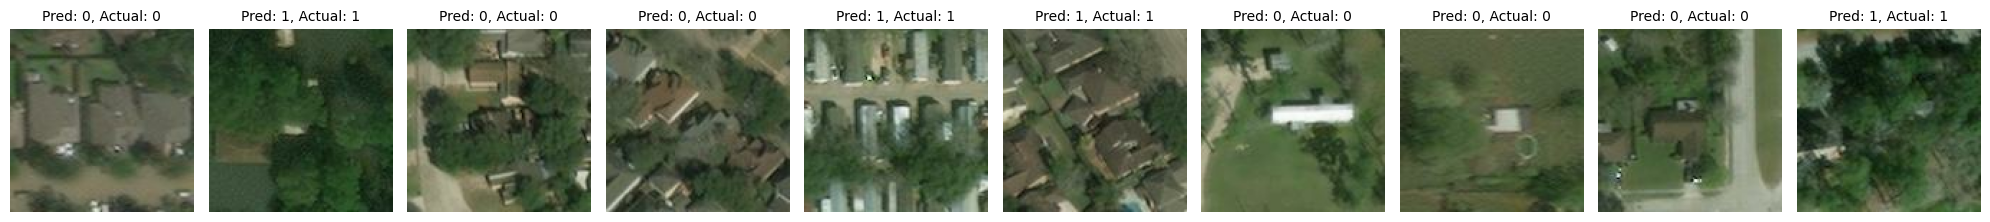

In [37]:
y_true, y_pred = eval_model_on_test(model)

In [38]:
eval = classification_report(y_true, y_pred)
print(eval)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      6333
           1       0.91      0.94      0.93      5895

    accuracy                           0.93     12228
   macro avg       0.93      0.93      0.93     12228
weighted avg       0.93      0.93      0.93     12228



# Threr was no clear improvement by unferezzeing the CONV5 layers, let's do one more fine tuning step to see if we can still get better results

In [39]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [40]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_1 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [41]:
# Fine-tune from this layer onwards
fine_tune_at = 81

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [42]:
for index, layer in enumerate(base_model.layers):
  print(index, ':', layer.name, '->', layer.trainable)

0 : input_1 -> False
1 : conv1_pad -> False
2 : conv1_conv -> False
3 : conv1_bn -> False
4 : conv1_relu -> False
5 : pool1_pad -> False
6 : pool1_pool -> False
7 : conv2_block1_1_conv -> False
8 : conv2_block1_1_bn -> False
9 : conv2_block1_1_relu -> False
10 : conv2_block1_2_conv -> False
11 : conv2_block1_2_bn -> False
12 : conv2_block1_2_relu -> False
13 : conv2_block1_0_conv -> False
14 : conv2_block1_3_conv -> False
15 : conv2_block1_0_bn -> False
16 : conv2_block1_3_bn -> False
17 : conv2_block1_add -> False
18 : conv2_block1_out -> False
19 : conv2_block2_1_conv -> False
20 : conv2_block2_1_bn -> False
21 : conv2_block2_1_relu -> False
22 : conv2_block2_2_conv -> False
23 : conv2_block2_2_bn -> False
24 : conv2_block2_2_relu -> False
25 : conv2_block2_3_conv -> False
26 : conv2_block2_3_bn -> False
27 : conv2_block2_add -> False
28 : conv2_block2_out -> False
29 : conv2_block3_1_conv -> False
30 : conv2_block3_1_bn -> False
31 : conv2_block3_1_relu -> False
32 : conv2_block3_2_

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

Epoch 1/10
34/34 [==============================] - 24s 144ms/step - loss: 0.0878 - accuracy: 0.9641 - val_loss: 0.2240 - val_accuracy: 0.9336
Epoch 2/10
34/34 [==============================] - 4s 91ms/step - loss: 0.0588 - accuracy: 0.9816 - val_loss: 0.2396 - val_accuracy: 0.9336
Epoch 3/10
34/34 [==============================] - 4s 102ms/step - loss: 0.0315 - accuracy: 0.9880 - val_loss: 0.2543 - val_accuracy: 0.9373
Epoch 4/10
34/34 [==============================] - 4s 92ms/step - loss: 0.0254 - accuracy: 0.9917 - val_loss: 0.2381 - val_accuracy: 0.9446
Epoch 5/10
34/34 [==============================] - 4s 92ms/step - loss: 0.0367 - accuracy: 0.9871 - val_loss: 0.2337 - val_accuracy: 0.9373
Epoch 6/10
34/34 [==============================] - 4s 108ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.2633 - val_accuracy: 0.9410


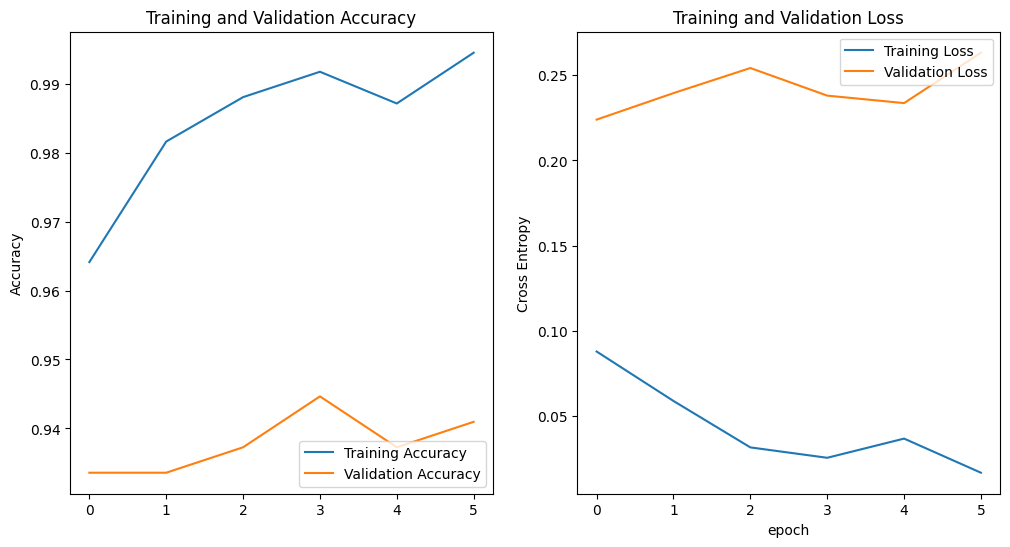

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 47ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:49,  1.78s/it]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:27,  1.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<01:01,  1.52it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:47,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:03<00:41,  2.21it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:03<00:37,  2.42it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:32,  2.77it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:28,  3.07it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:04<00:26,  3.32it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:04<00:24,  3.49it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:23,  3.69it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:21,  3.86it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:05<00:21,  3.93it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:20,  3.99it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:20,  3.94it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:20,  3.97it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:06<00:19,  3.99it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:19,  3.99it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:06<00:19,  4.02it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:06<00:18,  4.02it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:18,  4.03it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:07<00:18,  4.05it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:07<00:17,  4.07it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:07<00:17,  4.04it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:08<00:17,  4.01it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:08<00:17,  4.03it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:08<00:17,  3.98it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:08<00:17,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:09<00:16,  3.95it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:09<00:16,  3.94it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:16,  3.95it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:09<00:16,  3.93it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:16,  3.93it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:10<00:15,  3.95it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:10<00:15,  4.03it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:10<00:15,  3.95it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:11<00:14,  3.96it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:11<00:14,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:11<00:14,  4.01it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:11<00:13,  4.04it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:12<00:13,  4.03it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:12<00:13,  4.02it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:12<00:12,  4.08it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:12<00:12,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:13<00:12,  4.10it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:13<00:12,  4.07it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:13<00:12,  3.85it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:13<00:13,  3.63it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:14<00:13,  3.42it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:14<00:13,  3.42it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:14<00:13,  3.40it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:15<00:13,  3.31it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:15<00:13,  3.15it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:15<00:13,  3.12it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:16<00:13,  3.11it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:16<00:12,  3.32it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:16<00:11,  3.54it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:16<00:10,  3.69it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:17<00:09,  3.74it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:17<00:09,  3.81it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:17<00:09,  3.83it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:17<00:08,  3.88it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:18<00:08,  3.83it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:18<00:08,  3.87it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:18<00:07,  3.94it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:18<00:07,  3.92it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:19<00:07,  3.84it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:19<00:07,  3.88it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:19<00:06,  3.91it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:20<00:06,  3.96it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:20<00:06,  3.79it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:06,  3.82it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:20<00:05,  3.87it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:21<00:05,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:21<00:05,  3.92it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:05,  3.97it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:21<00:04,  4.02it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:22<00:04,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:22<00:04,  3.99it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:22<00:03,  4.05it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:03,  4.13it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:23<00:03,  4.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:23<00:03,  4.02it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:23<00:02,  4.08it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  4.19it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:23<00:02,  4.21it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:24<00:02,  4.18it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:24<00:01,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.15it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  4.23it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:25<00:01,  4.28it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:25<00:00,  4.25it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:25<00:00,  4.35it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  4.38it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:26<00:00,  4.39it/s]

3/3 [==============================] - 1s 30ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


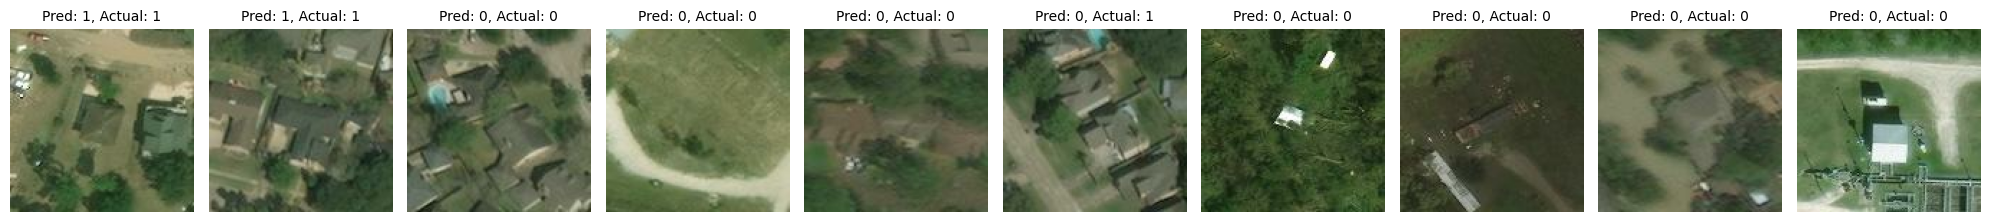

In [45]:
y_true, y_pred = eval_model_on_test(model)

In [46]:
eval = classification_report(y_true, y_pred)
print(eval)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6333
           1       0.94      0.92      0.93      5895

    accuracy                           0.93     12228
   macro avg       0.94      0.93      0.93     12228
weighted avg       0.93      0.93      0.93     12228



# As it seems finetuning the model did not get me any better results